# Import supporting package

In [1]:
import xarray as xr
import numpy as np

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

import matplotlib.pyplot as plt

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:50503' processes=6 threads=60, memory=55.88 GiB>

## Set global path for experiment

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_1",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_2",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_3",
}


In [4]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Repetition_scan" + "/"
folderPath = img_dir + SequenceName + '2023/' + get_date()

# An example for one experimental run

## Load the data

In [5]:
shotNum = "0000"
filePath = folderPath + "/" + shotNum + "/*.h5"
filePath = "//DyLabNAS/Data/Repetition_scan/2023/04/21/0002/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in range(len(groupList))
}

dataSet = dataSetDict["camera_1"]

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

<xarray.Dataset>
Dimensions:     (final_amp: 11, runs: 3, x: 1200, y: 1920)
Coordinates:
  * final_amp   (final_amp) float64 3e-05 5.5e-05 8e-05 ... 0.000255 0.00028
  * runs        (runs) float64 0.0 1.0 2.0
Dimensions without coordinates: x, y
Data variables:
    atoms       (final_amp, runs, x, y) uint16 dask.array<chunksize=(9, 3, 1200, 1920), meta=np.ndarray>
    background  (final_amp, runs, x, y) uint16 dask.array<chunksize=(9, 3, 1200, 1920), meta=np.ndarray>
    dark        (final_amp, runs, x, y) uint16 dask.array<chunksize=(9, 3, 1200, 1920), meta=np.ndarray>
    shotNum     (final_amp, runs) int64 dask.array<chunksize=(11, 3), meta=np.ndarray>
    OD          (final_amp, runs, x, y) float64 dask.array<chunksize=(9, 3, 1200, 1920), meta=np.ndarray>
Attributes: (12/96)
    TOF_free:                          0.01
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    z_offset:                          0.189
    z_offset_img:                      0.189
    final_amp:                         [3.00e-05 5.50e-05 8.00e-05 1.05e-04 1...
    runs:                              [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1...
    scanAxis:                          ['final_amp', 'runs']
    scanAxisLength:                    [33. 33.]

## Calculate an plot OD images

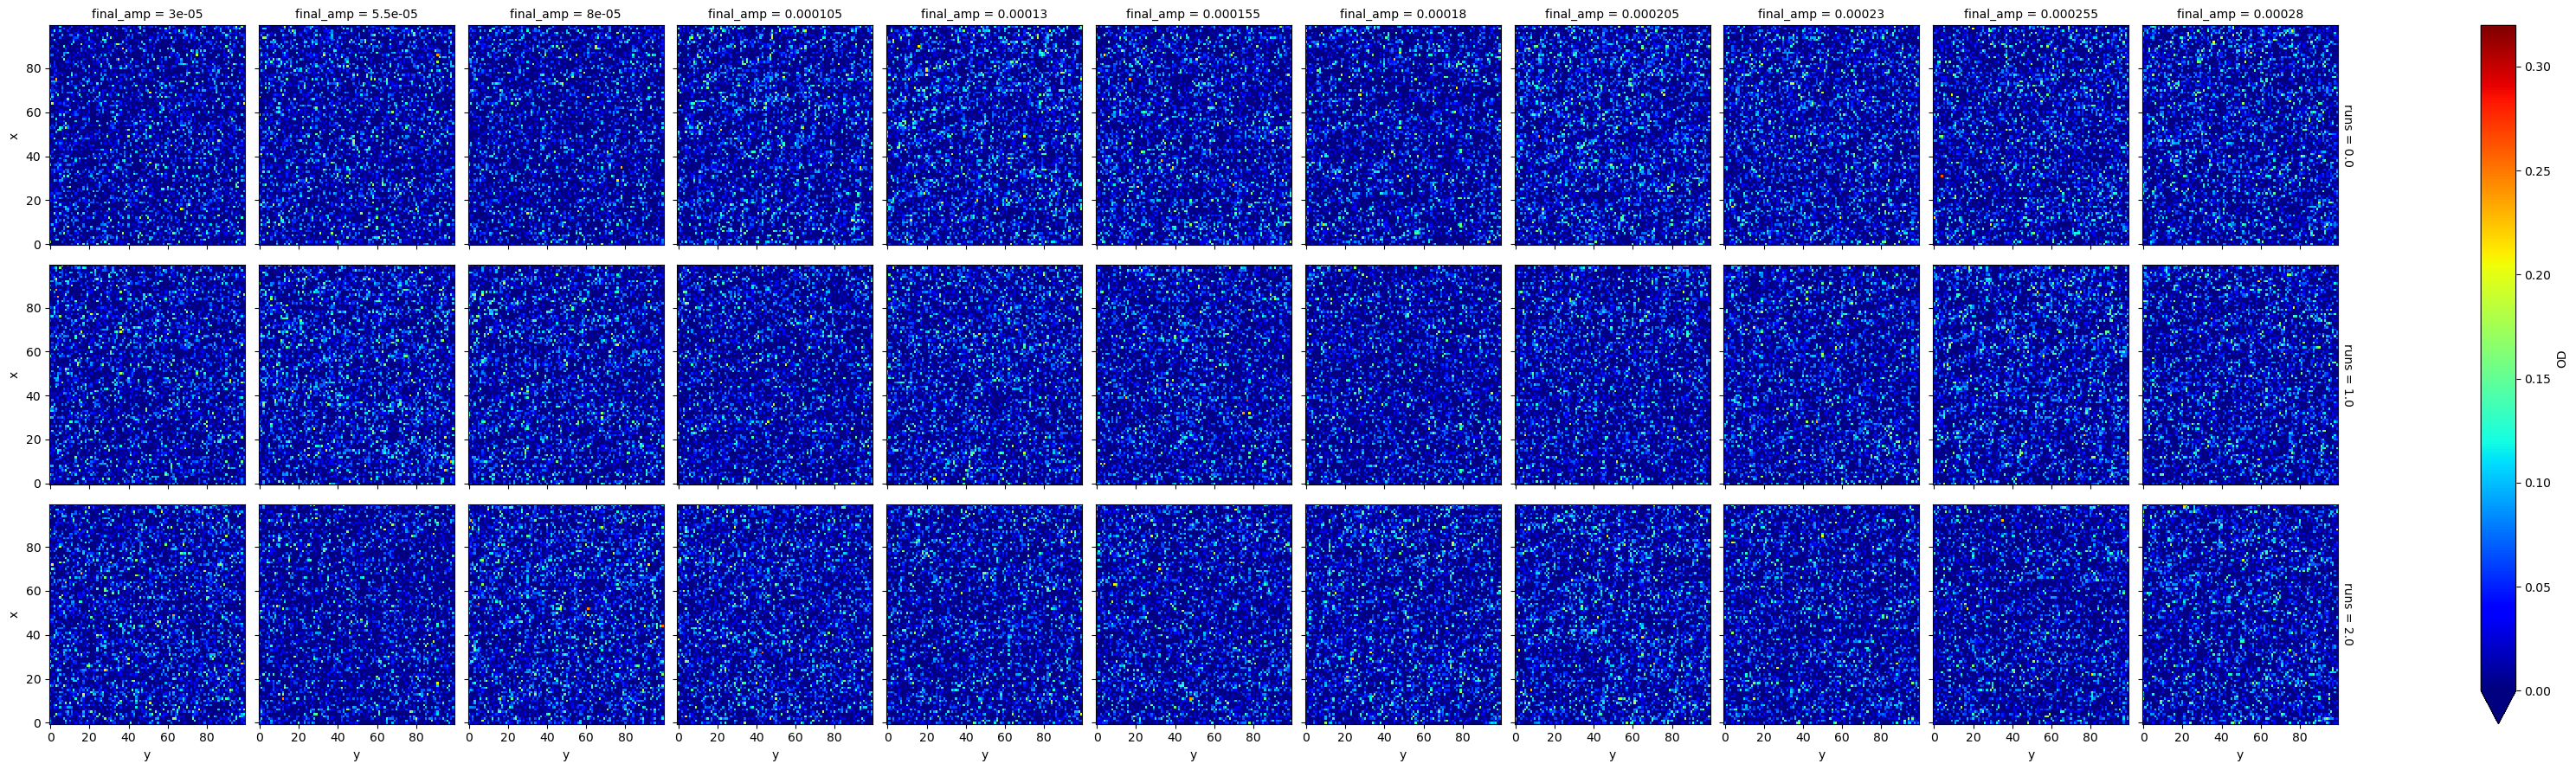

In [6]:
imageAnalyser.center = (890, 950)
imageAnalyser.span = (100,100)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

## Do a 2D two-peak gaussian fit to the OD images

### Do the fit

In [7]:
fitAnalyser = FitAnalyser("Two Gaussian-2D", fitDim=2)

params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params).load()

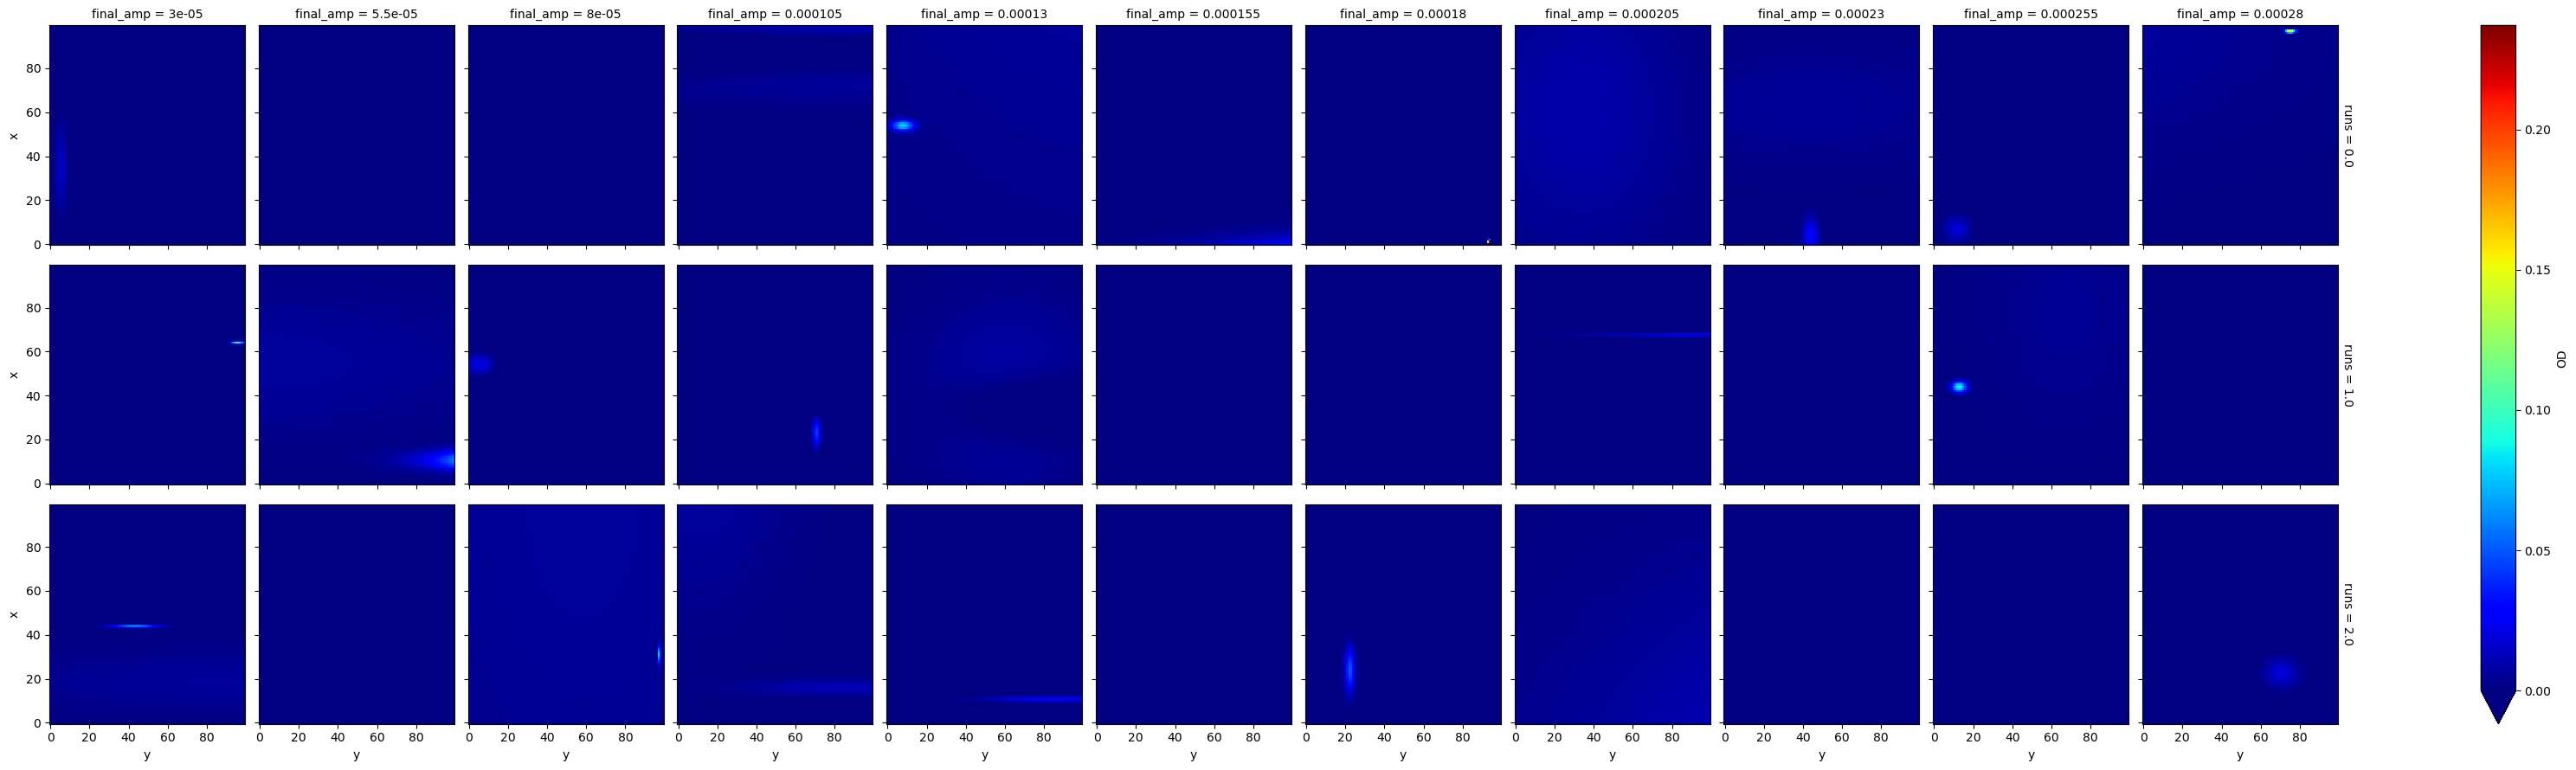

In [8]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(100), y=np.arange(100), dask="parallelized").load()

fitCurve.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])

### Get the result of the fit

In [9]:
fitAnalyser.get_fit_value(fitResult)

<xarray.Dataset>
Dimensions:      (final_amp: 11, runs: 3)
Coordinates:
  * final_amp    (final_amp) float64 3e-05 5.5e-05 8e-05 ... 0.000255 0.00028
  * runs         (runs) float64 0.0 1.0 2.0
Data variables:
    A_amplitude  (final_amp, runs) float64 7.389 0.6514 2.918 ... -2.518 3.549
    A_centerx    (final_amp, runs) float64 5.522 95.78 43.32 ... 41.19 70.74
    A_centery    (final_amp, runs) float64 36.45 63.99 43.59 ... 31.02 22.72
    A_sigmax     (final_amp, runs) float64 2.715 2.318 8.417 ... 1.901 6.007
    A_sigmay     (final_amp, runs) float64 18.7 0.4659 0.2433 ... 5.352 4.693
    B_amplitude  (final_amp, runs) float64 -1.332e+03 -5.867 ... 186.6 -94.97
    B_centerx    (final_amp, runs) float64 -62.62 85.42 87.56 ... -80.55 -52.57
    B_centery    (final_amp, runs) float64 145.8 79.83 18.89 ... 101.4 74.86
    B_sigmax     (final_amp, runs) float64 120.4 30.64 91.5 ... 26.64 116.1
    B_sigmay     (final_amp, runs) float64 119.6 2.057 11.05 ... 99.89 49.72
    delta        (final_amp, runs) float64 -117.7 -28.32 ... -24.74 -110.1

In [10]:
fitAnalyser.get_fit_std(fitResult)

<xarray.Dataset>
Dimensions:      (final_amp: 11, runs: 3)
Coordinates:
  * final_amp    (final_amp) float64 3e-05 5.5e-05 8e-05 ... 0.000255 0.00028
  * runs         (runs) float64 0.0 1.0 2.0
Data variables:
    A_amplitude  (final_amp, runs) float64 3.417 0.3964 3.144e+05 ... 0.99 1.785
    A_centerx    (final_amp, runs) float64 0.8112 1.075 3.288 ... 0.7478 2.814
    A_centery    (final_amp, runs) float64 6.057 0.4854 ... 2.086 2.182
    A_sigmax     (final_amp, runs) float64 0.9314 1.173 3.294 ... 0.7483 2.864
    A_sigmay     (final_amp, runs) float64 6.576 0.2286 8.649e+03 ... 2.088 2.22
    B_amplitude  (final_amp, runs) float64 6.054e+03 6.17 ... 1.299e+03
    B_centerx    (final_amp, runs) float64 475.1 36.46 ... 1.294e+05 1.611e+03
    B_centery    (final_amp, runs) float64 342.8 0.9901 ... 3.967e+04 76.89
    B_sigmax     (final_amp, runs) float64 255.8 30.52 285.1 ... 1.969e+04 956.2
    B_sigmay     (final_amp, runs) float64 221.4 0.9901 ... 3.959e+04 86.02
    delta        (final_amp, runs) float64 255.5 30.55 285.1 ... 1.969e+04 956.2

In [11]:
fitAnalyser.get_fit_full_result(fitResult)

C:\Users\data\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2246: RuntimeWarning: invalid value encountered in _get_fit_full_result_single (vectorized)
  outputs = ufunc(*inputs)


<xarray.Dataset>
Dimensions:      (final_amp: 11, runs: 3)
Coordinates:
  * final_amp    (final_amp) float64 3e-05 5.5e-05 8e-05 ... 0.000255 0.00028
  * runs         (runs) float64 0.0 1.0 2.0
Data variables:
    A_amplitude  (final_amp, runs) object 7.4+/-3.4 0.7+/-0.4 ... 3.5+/-1.8
    A_centerx    (final_amp, runs) object 5.5+/-0.8 95.8+/-1.1 ... 70.7+/-2.8
    A_centery    (final_amp, runs) object 36+/-6 64.0+/-0.5 ... 22.7+/-2.2
    A_sigmax     (final_amp, runs) object 2.7+/-0.9 2.3+/-1.2 ... 6.0+/-2.9
    A_sigmay     (final_amp, runs) object 19+/-7 0.47+/-0.23 ... 4.7+/-2.2
    B_amplitude  (final_amp, runs) object (-1+/-6)e+03 ... (-0.1+/-1.3)e+03
    B_centerx    (final_amp, runs) object (-1+/-5)e+02 ... (-0.1+/-1.6)e+03
    B_centery    (final_amp, runs) object (1.5+/-3.4)e+02 ... (7+/-8)e+01
    B_sigmax     (final_amp, runs) object (1.2+/-2.6)e+02 ... (0.1+/-1.0)e+03
    B_sigmay     (final_amp, runs) object (1.2+/-2.2)e+02 ... (5+/-9)e+01
    delta        (final_amp, runs) object (-1.2+/-2.6)e+02 ... (-0.1+/-1.0)e+03

## Get the Ncount

### Calculate the mean and standard deviation

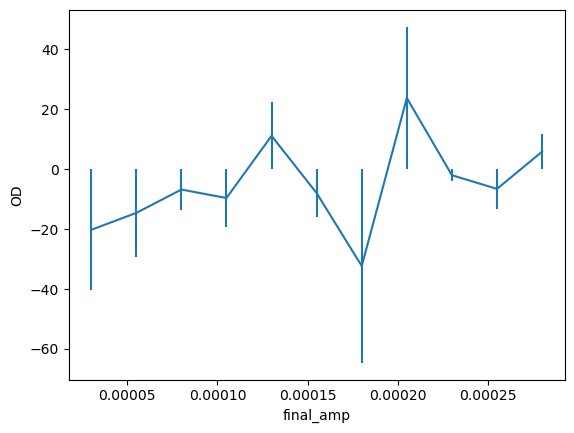

In [41]:
Ncount = imageAnalyser.get_Ncount(dataSet_cropOD)

Ncount.load()
Ncount_mean = calculate_mean(Ncount)
Ncount_std = calculate_std(Ncount)
Ncount_mean.plot.errorbar(yerr=Ncount_std)
plt.show()

###  Do a 1D fit

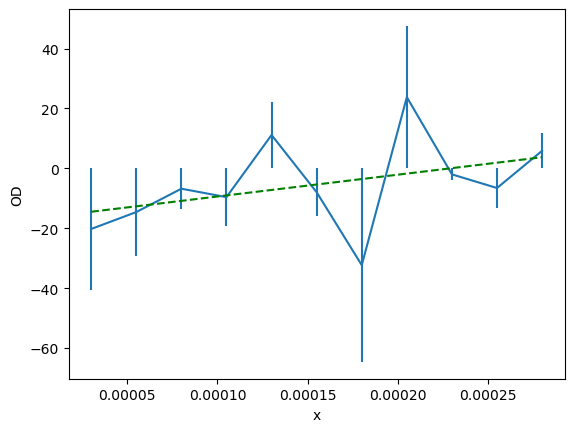

In [42]:
fitAnalyser = FitAnalyser("Linear", fitDim=1)

params = fitAnalyser.guess(Ncount_mean, x="final_amp", dask="parallelized")
fitResult = fitAnalyser.fit(Ncount_mean, params, x="final_amp").load()

plot_x = np.linspace(Ncount_mean["final_amp"].min(), Ncount_mean["final_amp"].max(), 100)

fitCurve = fitAnalyser.eval(fitResult, x=plot_x, dask="parallelized").load()

fig = plt.figure()
ax = fig.gca()

Ncount_mean.plot.errorbar(ax=ax, yerr=Ncount_std)
fitCurve.plot.errorbar(ax=ax, fmt='--g')

plt.show()

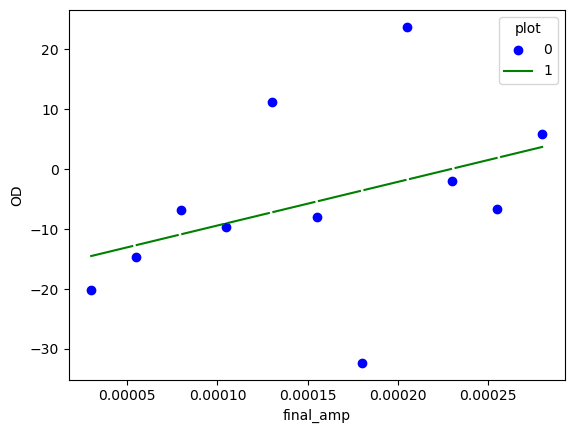

In [43]:
fitCurve = fitCurve.rename(dict(x='final_amp'))
plot_dataSe = xr.combine_nested([Ncount_mean, fitCurve], ['plot'])

fig = plt.figure()
ax = fig.gca()
plot_dataSe.sel(plot=[0, 1]).plot.errorbar(ax=ax, hue='plot', x='final_amp', fmt=['ob', '-g'])
plt.show()


# Select data and remove bad shot

In [39]:
plot_dataSe.where( (Ncount_mean[scanAxis[0]]<2e-4) & (Ncount_mean[scanAxis[0]]>1e-4) )

<xarray.DataArray 'OD' (plot: 2, final_amp: 11)>
array([[         nan,          nan,          nan,  -9.60933756,
         11.14172055,  -7.97310057, -32.31393233,          nan,
                 nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan]])
Coordinates:
  * final_amp  (final_amp) float64 3e-05 5.5e-05 8e-05 ... 0.000255 0.00028
Dimensions without coordinates: plot